In [113]:
figwidth = 4*2.5
golden = 1.61
figheight = figwidth/golden

import matplotlib.pyplot as plt
import matplotlib.cm as cmap
cm = cmap.inferno

plt.style.use("../thesis-style.mpl")

In [2]:
import numpy as np
import scipy as sp
import theano
import theano.tensor as tt
import theano.tensor.nlinalg
import sys
#sys.path.insert(0, "../../..")
import pymc3 as pm

In [3]:
import pandas as pd

In [4]:
hills = pd.read_json("hills-list.json")

In [5]:
alps = hills[hills['range'].str.contains("Arrochar")]

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


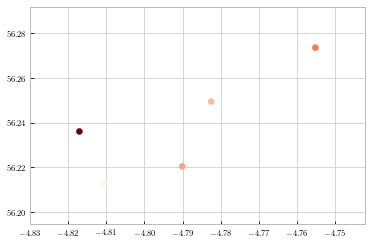

In [6]:
plt.scatter(alps['lon'], alps['lat'], c=alps['height'], cmap='Reds')#, 'o', color='k')
#for i, txt in enumerate(n):
#plt.annotate(np.array(alps['height']), (np.array(alps['lat']), np.array(alps['lon'])))

In [7]:
thesis_colors = {"blue": "#348ABD", "red": "#E24A33"}

In [8]:
lons = np.linspace(-4.85, -4.70, 20)
lats = np.linspace(56.20, 56.28, 20)
points = np.transpose([np.tile(lons, len(lats)), np.repeat(lats, len(lons))])

In [9]:
points.shape

(400, 2)

In [10]:
cov_func = pm.gp.cov.ExpQuad(2, ls=1)

In [11]:
X = points
K = cov_func(X).eval()

In [18]:
draws = pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=1).T

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


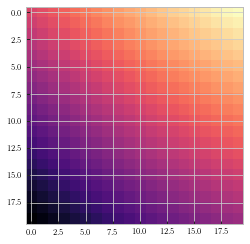

In [19]:
plt.imshow(draws.reshape(20,20))

array([[-4.8170373 , 56.236013  ],
       [-4.790082  , 56.220445  ],
       [-4.7825008 , 56.249379  ],
       [-4.7551643 , 56.27336   ],
       [-4.81072257, 56.21283146]])

In [205]:
with pm.Model() as model:
    
    amp = pm.Normal("amplitude", 5000, 20)
    ls = pm.Normal("metric", 0.015, 0.1) #pm.Gamma("metric", alpha=3, beta=0.5, shape=2)
    #period = pm.Gamma("period", alpha=1, beta=0.5)
    
    # Specify the covariance function.
    cov_func = amp * pm.gp.cov.ExpQuad(2, ls=ls)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0, 0.02)
    y_ = gp.marginal_likelihood("y", X=np.vstack([alps['lon'], alps['lat']]).T, y=np.array(alps['height']), noise=sigma)

In [206]:
with model:
    mp = pm.find_MAP()

logp = -352.19, ||grad|| = 17,661: 100%|██████████| 9/9 [00:00<00:00, 428.21it/s]


In [207]:
lons = np.linspace(-4.85, -4.70, 100)
lats = np.linspace(56.20, 56.28, 100)
points = np.transpose([np.tile(lons, len(lats)), np.repeat(lats, len(lons))])

In [208]:
with model:
    mu, var = gp.predict(points, point=mp, diag=True)
    sd = np.sqrt(var)

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'lw', 'lc'
  s)


/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


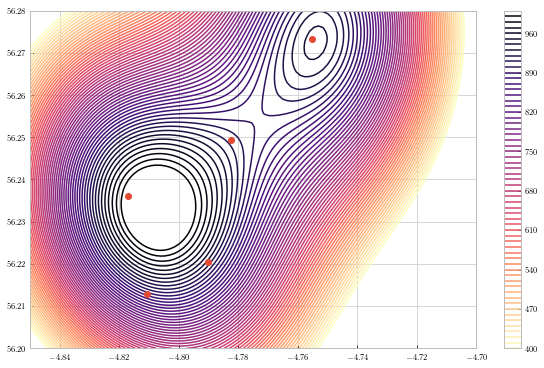

In [209]:
plt.figure(figsize=(figwidth, figheight))
plt.contour(lons, lats, (mu.reshape(100,100)), levels=np.arange(400, 1010, 10), lw=1, lc='orange')
#plt.imshow(mu.reshape(100,100), extent=[lons.min(), lons.max(), lats.min(), lats.max()])
plt.plot(alps['lon'], alps['lat'], 'o')
plt.colorbar()

In [211]:
with model:
    f_pred = gp.conditional("f_pred", points)

In [212]:
with model:
    pred_samples = pm.sample_ppc([mp], vars=[f_pred], samples=4)

100%|██████████| 4/4 [01:24<00:00, 21.19s/it]


In [210]:
mp

{'amplitude': array(5000.00000053),
 'metric': array(0.03646728),
 'sigma': array(0.)}